![log](images/dataworks-logo.png)
![ccdc](images/logo.png)

# Convolutional Neural Networks 


## Brief Description 

So far, data in tensor-structure was flattened into a single dimension before being processed by a machine learning algorithm.  Convolutional neural networks provide a means to **retain spatial structure** of data.  


+ Connect patches of input to neurons in the hidden layer.  Each neuron will only see a region of the data.  
+ Assuming that pixels that are spatially close are somewhat related 

### Convolution operation 

The convolution operation is a pair-wise multiplication and sum of a sliding filter (aka kernel) over an input tensor.  

![conv-mult](images/conv-mult.gif)


### Convolving over volumes 
A filter will have the same depth (channel dimension) as the input.  In RBG color images, that depth is 3.  In the gif below, the filter (aka kernel) is of shape (3x3x3).  The input shape is (H, W, 3).  The convolution operation remains the same, and each channel output of the filter is added together.  

![](images/conv-volume-1filter.gif)



### Multiple filters 

The result of one of ANY dimension filter on ANY spatial dimension volume will result in a ONE-depth-unit tensor.  

The outputs of multiple filters are stacked together along the depth/channel dimension.  In gif below, see that the output is (3x3x2), because there were two filters being applied.  

![](images/conv-volume-2filters.gif)

---


> You may need to install [pillow](https://pillow.readthedocs.io/en/stable/) to run this notebook.  
> `conda install -c conda-forge pillow`

In [1]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt 

from PIL import Image 

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D

print(tf.__version__)

2.4.1


## `tensorflow.keras.layers.Conv2D`

[docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 

Conv2D is tensorflow's implementation of a convolutional layer.  "2D" refers to the non-channel dimensions.  For images, channels are usually the color channels (RGB).  Therefore, 2D color/blackwhite images are valid inputs to Conv2D.  The weight vector will automatically match the number of channels that is input to the layer.  See this [post](https://datascience.stackexchange.com/questions/51470/what-are-the-differences-between-convolutional1d-convolutional2d-and-convoluti) for more details.  

There is also Conv3D.  This is used for data that has 3 dimensions (besides the channel dimension).  


In [2]:
conv_layer = Conv2D(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')

## Effects of a filter on an image 

We will construct three convolutional layers and set predefined weight tensors to them.  They will be applied to an input image of a slurpy doge.  In observing the output of the layers, we hope to see the effect of the filters.  

In [3]:
IMG_H, IMG_W, CHANNELS = (100, 100, 3)

Text(0.5, 1.0, 'Processed Img')

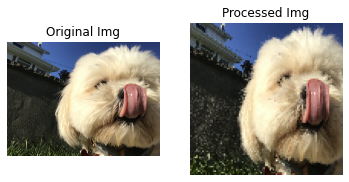

In [4]:
# Read in image and preprocess 

img_str = tf.io.read_file('images/slurp.jpg')
img_dec = tf.image.decode_jpeg(img_str)
img_dec = tf.image.convert_image_dtype(img_dec, dtype=tf.float32, saturate=False)
img_reduced = tf.image.resize(img_dec, (IMG_H, IMG_W))
img_data = np.expand_dims(img_reduced, axis=0)
img_data = img_data / 255.0

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img_dec)
axes[0].axis(False)
axes[0].set_title('Original Img')

axes[1].imshow(img_reduced)
axes[1].axis(False)
axes[1].set_title('Processed Img')


### Building the filters 

In [5]:
conv_layer_1 = Conv2D(1, kernel_size=(3, 3), padding='same', input_shape=(IMG_H, IMG_W, CHANNELS), activation='relu')
conv_layer_2 = Conv2D(1, kernel_size=(3, 3), padding='same', input_shape=(IMG_H, IMG_W, CHANNELS), activation='relu')
conv_layer_3 = Conv2D(1, kernel_size=(3, 3), padding='same', input_shape=(IMG_H, IMG_W, CHANNELS), activation='relu')

#must be invoked to initialize weights.  Need to be initialized in order to set a filter
conv_layer_1(img_data);  
conv_layer_2(img_data);  
conv_layer_3(img_data); 

In [6]:
filter_1 = np.array([[[1, 1, 1],
                      [0, 0, 0],
                      [-1, -1, -1]], 
                   
                     [[1, 1, 1],
                      [0, 0, 0],
                      [-1, -1, -1]], 
                   
                      [[1, 1, 1],
                       [0, 0, 0],
                       [-1, -1, -1]]]) 
filter_1 = np.expand_dims(filter_1, axis=-1)

filter_2 = filter_1 * -1

filter_3 = np.rot90(filter_2)

# set_weights = (weights, bias) 
conv_layer_1.set_weights([filter_1, np.array([0])])
conv_layer_2.set_weights([filter_2, np.array([0])])
conv_layer_3.set_weights([filter_3, np.array([0])])

### Visualize the filters

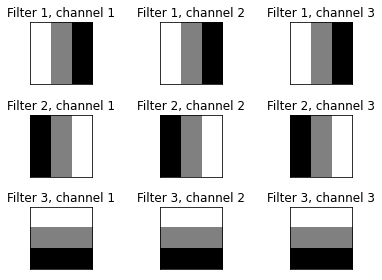

In [7]:
filters = [filter_1, filter_2, filter_3]
fig, axes = plt.subplots(3, 3)

for idx, axes_r in enumerate(axes): 
    
    f = filters[idx]
    for idx_2, ax in enumerate(axes_r): 
        ax.imshow(f[:, :, idx_2, 0], cmap=mlp.cm.binary_r)
        ax.set_title("Filter {}, channel {}".format(idx+1, idx_2+1))
        ax.set_yticks([])
        ax.set_xticks([])
        
plt.tight_layout()

### Apply the filters across each image and plot the output.  

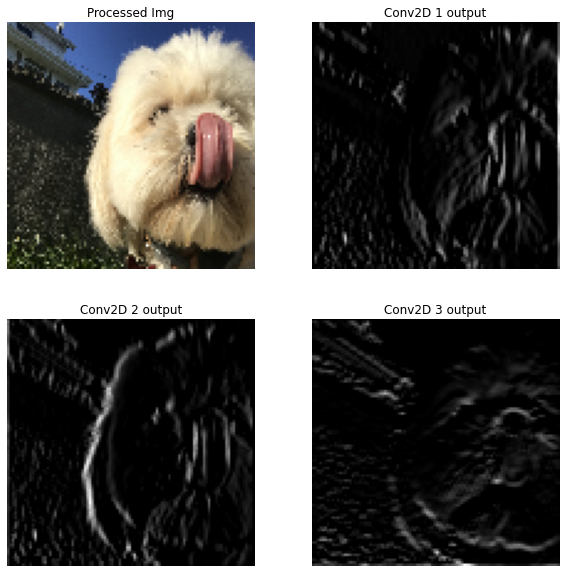

In [8]:
layers = [conv_layer_1, conv_layer_2, conv_layer_3]
outs = []

for layer in layers: 

    out = layer(img_data)
    out = np.squeeze(out, axis=0)
    out = np.squeeze(out, axis=-1)
    outs.append(out)
    

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.reshape(-1)


for idx, ax in enumerate(axes): 
    if idx == 0: 
        ax.imshow(img_reduced)
        ax.axis(False)
        ax.set_title('Processed Img') 
        continue 
        
    ax.imshow(outs[idx-1], cmap=mlp.cm.binary_r)
    ax.axis(False)
    ax.set_title('Conv2D {} output'.format(idx))

Note that the lighter areas indicate nodes/neurons that are "excited" and pass a strong positive signal forward.  Each filter seems to be "excited" by different visual patterns.  In this case, we see **edge detection**.   

---
---
## Simple ConvNet

Let's demonstrate the use of a convolutional neural network using the [Fashion MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist).  The Fashion MNIST dataset consists of 28x28 black and white images of 10 classes.  Each class is a different article of clothing.     

### Data setup

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize images 
train_images = train_images / 255.0
test_images = test_images / 255.0

Split the test set into validation and test sets.  

In [10]:
from sklearn.model_selection import train_test_split 

val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5)

Since we plan on using Conv2D, we need to add a dimension that represents the channel dimension.  The fashion MNIST dataset is blackwhite, so the channel dimension is 1.  

In [11]:
print("Dimensions before: ", train_images.shape, val_images.shape, test_images.shape)

train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

print("Dimensions after: ", train_images.shape, val_images.shape, test_images.shape)

Dimensions before:  (60000, 28, 28) (5000, 28, 28) (5000, 28, 28)
Dimensions after:  (60000, 28, 28, 1) (5000, 28, 28, 1) (5000, 28, 28, 1)


In [12]:
N_SAMPLES, IMG_H, IMG_W, CHANNELS = train_images.shape

### Model building 

ConvNets are usually made up of pairs of (conv, pool) followed by a few dense layers.  
Generally, you will want to gradually **increase the depth** of the feature tensor (number of filters/channels) and **decrease the spatial dimensions** of the feature vector (height, width).  

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten 

model = tf.keras.Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(IMG_H, IMG_W, CHANNELS)),
    MaxPooling2D((2, 2)), 
    Conv2D(32, (3, 3), padding='same', activation='relu'), 
    MaxPooling2D((2, 2)), 
    Flatten(), 
    Dense(32, activation='relu'),
    Dense(10)  
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                50208     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**WARNING** This may take a while to run.  Set epochs to 10 is you're impatient.  

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_images, 
          train_labels, 
          epochs=10, 
          validation_data=(val_images, val_labels), 
          callbacks=[early_stopping], 
          verbose=1)

Epoch 1/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.6847 - accuracy: 0.7525 - val_loss: 0.3674 - val_accuracy: 0.8704
Epoch 2/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.3314 - accuracy: 0.8822 - val_loss: 0.3490 - val_accuracy: 0.8786
Epoch 3/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2783 - accuracy: 0.9008 - val_loss: 0.3231 - val_accuracy: 0.8882
Epoch 4/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.2533 - accuracy: 0.9107 - val_loss: 0.2863 - val_accuracy: 0.8996
Epoch 5/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.2296 - accuracy: 0.9183 - val_loss: 0.2924 - val_accuracy: 0.8980
Epoch 6/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2120 - accuracy: 0.9245 - val_loss: 0.2886 - val_accuracy: 0.9010
Epoch 7/10
1875/1875 [==============================] - 72s 39ms/step - loss: 0.1954 - accuracy: 0.9282 - val_loss: 0.2668 -

### Learning curve plot 

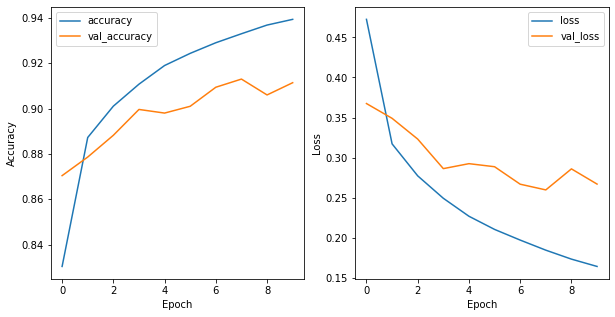

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(history.history['accuracy'], label='accuracy')
axes[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='loss')
axes[1].plot(history.history['val_loss'], label = 'val_loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

### Evaluate on test set 

In [18]:
model.evaluate(test_images, test_labels, verbose=1)

157/157 [==============================] - 1s 5ms/step - loss: 0.2532 - accuracy: 0.9134


[0.2532379627227783, 0.9133999943733215]

Pretty good compared to the [88%](https://www.tensorflow.org/tutorials/keras/classification) using a simple dense network!  With further hyperparameter tuning, we should be able to get this higher.   

# References 

+ https://d2l.ai/chapter_convolutional-neural-networks/index.html
+ https://www.youtube.com/watch?v=H-HVZJ7kGI0
+ https://www.youtube.com/watch?v=iaSUYvmCekI
+ https://www.coursera.org/specializations/deep-learning
+ http://deeplearning.net/tutorial/lenet.html
+ https://towardsdatascience.com/visualizing-the-fundamentals-of-convolutional-neural-networks-6021e5b07f69  



--- 
Bonus: Compare the number of parameters to how many we would have in a similar dense network.

In [19]:
# Make dense model to assess parameter count 
dense_model = tf.keras.Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, CHANNELS)),
    Dense(16*3*3*CHANNELS, activation='relu'),
    Dense(32*3*3*CHANNELS, activation='relu'), 
    Dense(32, activation='relu'),
    Dense(10)  
    
])

dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 144)               113040    
_________________________________________________________________
dense_3 (Dense)              (None, 288)               41760     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                9248      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 164,378
Trainable params: 164,378
Non-trainable params: 0
_________________________________________________________________


ConvNets make use of **parameter sharing**.  That is, the parameters in a layer (weight values in the filters) are shared across the input to that layer.  Weights in a dense layer are connected to the entire input.  

---